In [18]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 设置基本路径
base_dir = './Data/public'
csv_file = os.path.join(base_dir, 'public.csv')
root_dir = base_dir

# 读取CSV文件
annotations = pd.read_csv(csv_file)

annotations.describe()


,ground truth
count,5758.000000
mean,0.183050
std,0.386741
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



类别分布：
ground truth
0    4704
1    1054
Name: count, dtype: int64


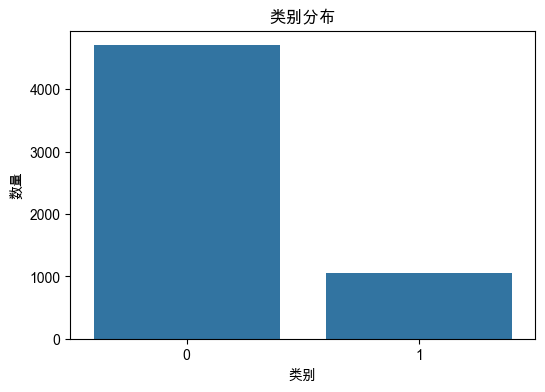

In [19]:
# 类别分布
print("\n类别分布：")
print(annotations['ground truth'].value_counts())

# 可视化类别分布
plt.figure(figsize=(6, 4))
sns.countplot(x='ground truth', data=annotations)
plt.title('类别分布')
plt.xlabel('类别')
plt.ylabel('数量')
plt.show()

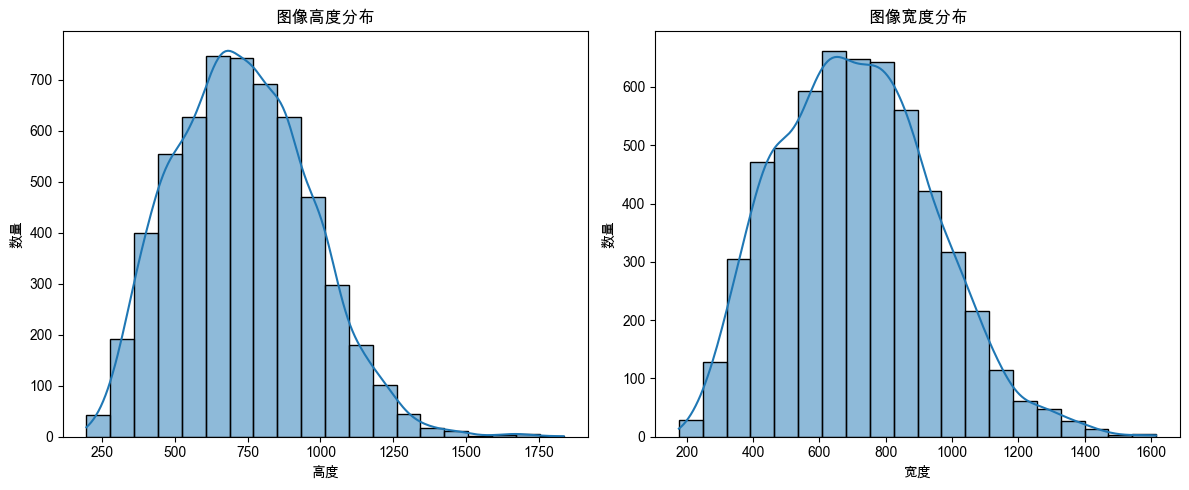

In [20]:
# 检查图像尺寸分布
img_dims = {'height': [], 'width': []}
for idx in range(len(annotations)):
    img_label = annotations.iloc[idx, 1]
    if img_label == 0:
        subdir = "non_globally_sclerotic_glomeruli"
    else:
        subdir = "globally_sclerotic_glomeruli"
    img_path = os.path.join(root_dir, subdir, annotations.iloc[idx, 0])
    with Image.open(img_path) as img:
        img_dims['height'].append(img.height)
        img_dims['width'].append(img.width)

# 可视化图像尺寸分布
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(img_dims['height'], bins=20, kde=True)
plt.title('图像高度分布')
plt.xlabel('高度')
plt.ylabel('数量')

plt.subplot(1, 2, 2)
sns.histplot(img_dims['width'], bins=20, kde=True)
plt.title('图像宽度分布')
plt.xlabel('宽度')
plt.ylabel('数量')

plt.tight_layout()
plt.show()

In [3]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda

class GlomeruliDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): 图片和标签的 CSV 文件路径。
            root_dir (string): 包含所有图片的目录路径。
            transform (callable, optional): 可选的转换操作，应用于样本。
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_label = self.annotations.iloc[idx, 1]
        if img_label == 0:
            subdir = "non_globally_sclerotic_glomeruli"
        else:
            subdir = "globally_sclerotic_glomeruli"
        img_name = os.path.join(self.root_dir, subdir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return (image, label)

# 定义预处理转换
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])
# 设置基本路径
base_dir = './Data/public'
csv_file = os.path.join(base_dir, 'public.csv')
root_dir = base_dir

# 创建数据集
dataset = GlomeruliDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# 分割数据集为训练集和测试集
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print("数据集准备完毕。")


数据集准备完毕。


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 设计模型
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

print("训练完成。")

/Users/zhangtianyi/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zhangtianyi/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/zhangtianyi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch [1/10], Loss: 0.15012532156348848
Epoch [2/10], Loss: 0.06260371701500844
Epoch [3/10], Loss: 0.05193908194390436
Epoch [4/10], Loss: 0.03242047734864981
Epoch [5/10], Loss: 0.0405969392700677
Epoch [6/10], Loss: 0.02704569425602838
Epoch [7/10], Loss: 0.022723942881687737
Epoch [8/10], Loss: 0.02718669407254816
Epoch [9/10], Loss: 0.023984130711748246
Epoch [10/10], Loss: 0.009456999751137118
训练完成。


In [8]:
model_save_path = './model/model.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"模型已保存到 {model_save_path}")

模型已保存到 ./model/model.pth


In [11]:
# 验证模型
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'模型在测试集上的准确率: {100 * correct / total}%')

模型在测试集上的准确率: 97.39583333333333%
